In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
%matplotlib inline

In [2]:
df=pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin1')
mask=np.array(Image.open("/kaggle/input/word-cloud-5/stormtrooper_mask.png"))

In [3]:
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1,inplace=True)


In [5]:
df.rename(columns={"v1":"label","v2":"text"},inplace=True)


In [6]:
df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.shape


(5572, 2)

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
df.isnull().sum()


label    0
text     0
dtype: int64

In [10]:
df.duplicated().sum()


403

In [11]:
df.drop_duplicates(inplace=True)


In [12]:
df.duplicated().sum()


0

In [13]:
df["label"].value_counts()


label
ham     4516
spam     653
Name: count, dtype: int64

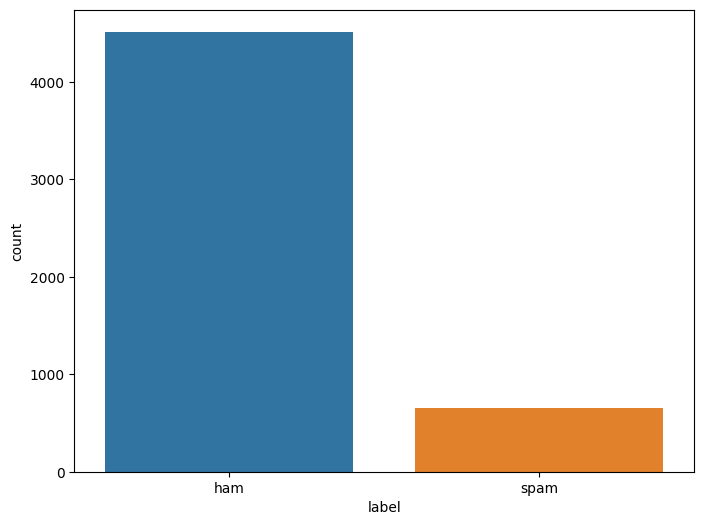

In [14]:
plt.figure(figsize=(8,6))
sns.countplot(x="label",data=df)
plt.show()

In [15]:
df['label'].replace({"ham": 0, "spam": 1}, inplace=True)


/tmp/ipykernel_18/2402810790.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].replace({"ham": 0, "spam": 1}, inplace=True)
/tmp/ipykernel_18/2402810790.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'].replace({"ham": 0, "spam": 1}, inplace=True)


In [16]:
df.head()


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Convert to lowercase
    text = text.lower()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [18]:
df["text"]=df["text"].apply(clean_text)

/tmp/ipykernel_18/1709735225.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [19]:
df['number_character']=df['text'].apply(len)
df['number_of_words'] = df['text'].apply(lambda x: len(x.split()))
df['number_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [20]:
df.head()

,label,text,number_character,number_of_words,number_sentence
0,0,go jurong point crazy available bugis n great ...,82,16,1
1,0,ok lar joking wif u oni,23,6,1
2,1,free entry wkly comp win fa cup final tkts st ...,101,21,1
3,0,u dun say early hor u c already say,35,9,1
4,0,nah think goes usf lives around though,38,7,1


In [21]:
df.describe()

,label,number_character,number_of_words,number_sentence
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,48.267557,8.691236,0.998646
std,0.332253,36.666598,6.350770,0.036778
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,21.000000,4.000000,1.000000
50%,0.000000,37.000000,7.000000,1.000000
75%,0.000000,71.000000,12.000000,1.000000
max,1.000000,447.000000,73.000000,1.000000


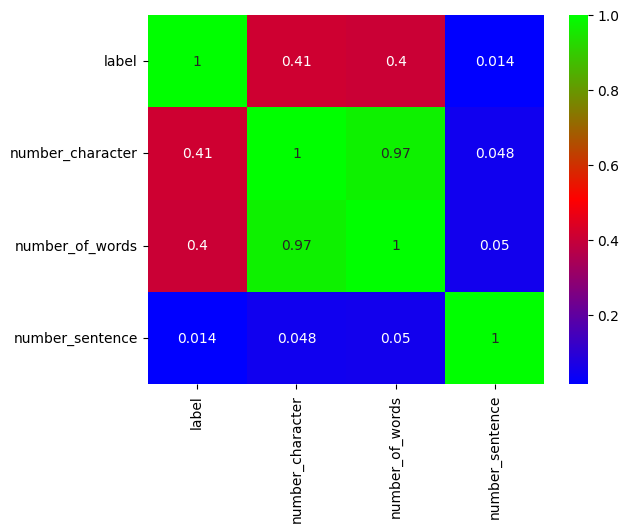

In [22]:
corr=df.select_dtypes(["int"]).corr()
sns.heatmap(corr,annot=True,cmap="brg")
plt.show()

In [23]:
df[["number_character","number_of_words","number_sentence"]].describe()

,number_character,number_of_words,number_sentence
count,5169.000000,5169.000000,5169.000000
mean,48.267557,8.691236,0.998646
std,36.666598,6.350770,0.036778
min,0.000000,0.000000,0.000000
25%,21.000000,4.000000,1.000000
50%,37.000000,7.000000,1.000000
75%,71.000000,12.000000,1.000000
max,447.000000,73.000000,1.000000


In [24]:
df[df["label"]==0][["number_character","number_of_words","number_sentence"]].describe()


,number_character,number_of_words,number_sentence
count,4516.000000,4516.000000,4516.000000
mean,42.524579,7.717671,0.998450
std,34.595643,5.960242,0.039344
min,0.000000,0.000000,0.000000
25%,19.000000,4.000000,1.000000
50%,32.000000,6.000000,1.000000
75%,56.000000,10.000000,1.000000
max,447.000000,73.000000,1.000000


In [25]:
df[df["label"]==1][["number_character","number_of_words","number_sentence"]].describe()


,number_character,number_of_words,number_sentence
count,653.000000,653.000000,653.0
mean,87.984686,15.424196,1.0
std,23.667749,4.660482,0.0
min,4.000000,1.000000,1.0
25%,77.000000,13.000000,1.0
50%,92.000000,16.000000,1.0
75%,104.000000,19.000000,1.0
max,142.000000,26.000000,1.0


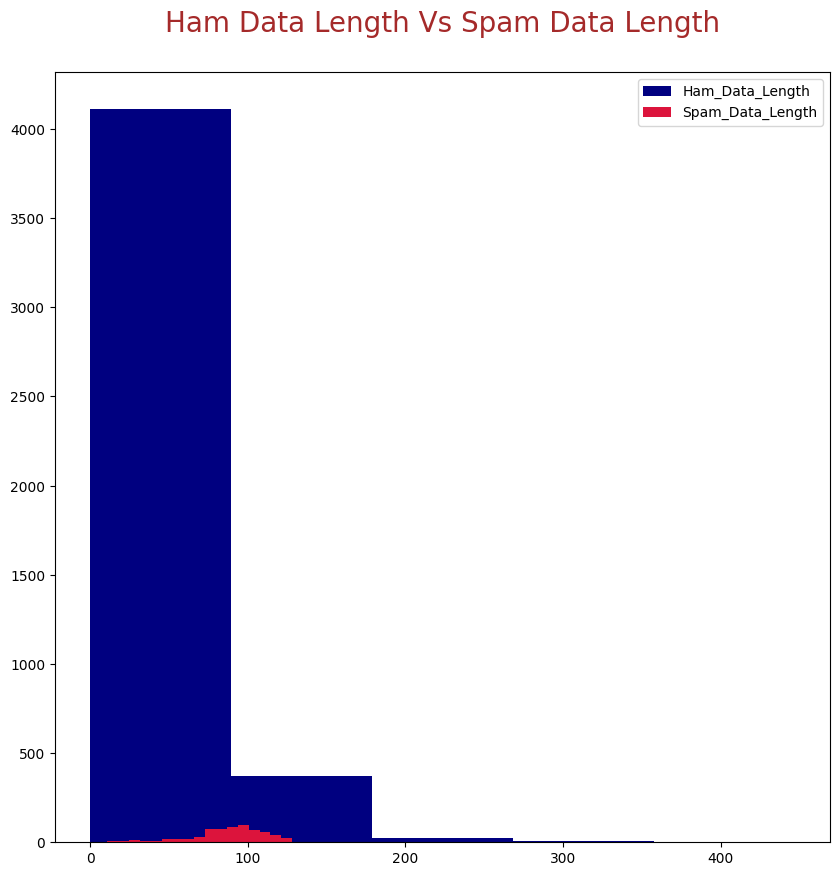

In [26]:
ham_data_len=df[df["label"]==0]["text"].str.len()
spam_data_len=df[df["label"]==1]["text"].str.len()
plt.figure(figsize=(10,10))
plt.hist(ham_data_len, bins=5,label='Ham_Data_Length',color="navy")
plt.hist(spam_data_len , bins=20, label='Spam_Data_Length',color="crimson")
plt.title("Ham Data Length Vs Spam Data Length\n",fontsize=20,color="brown")
plt.legend()
plt.show()

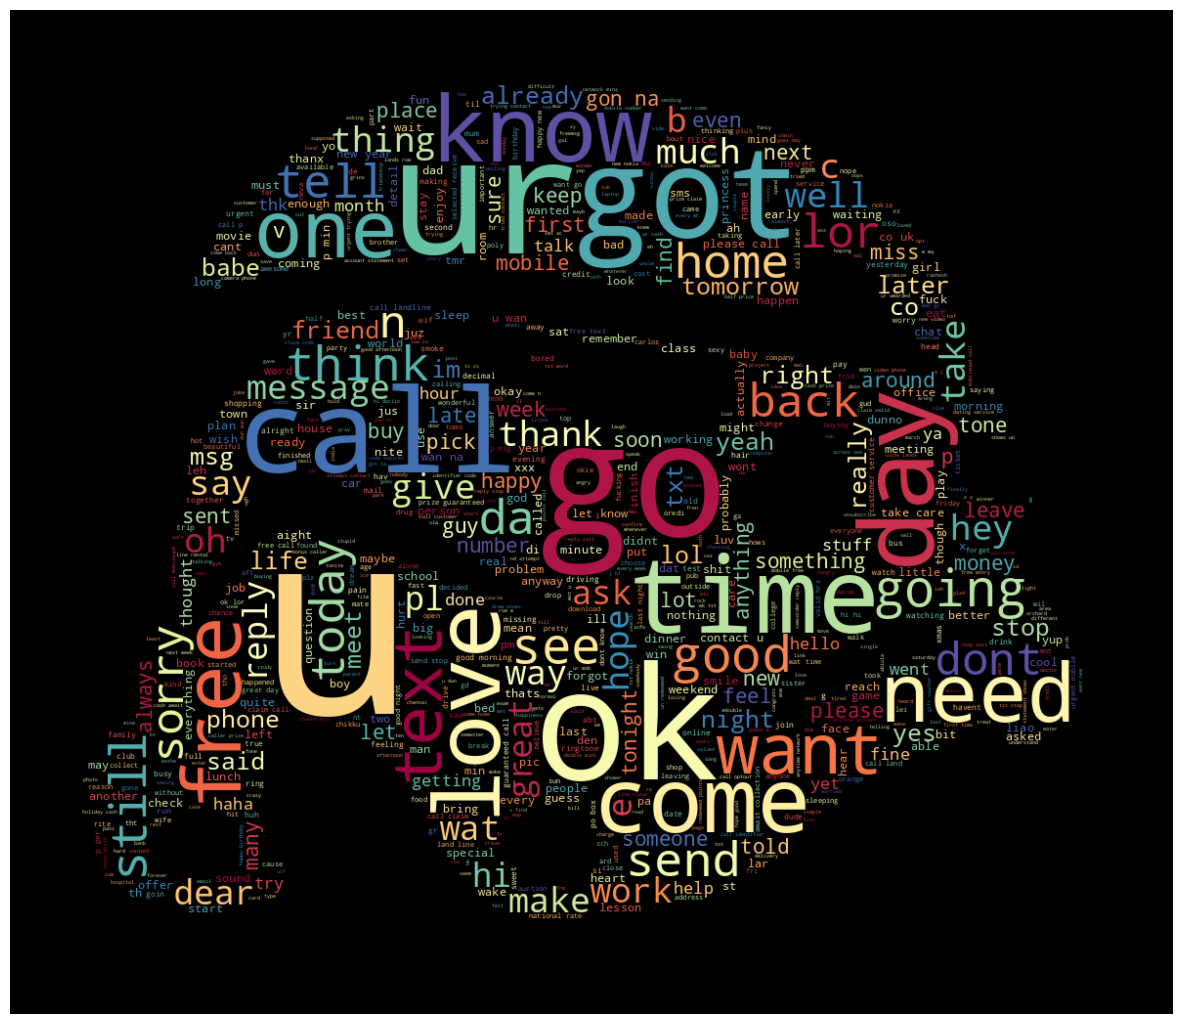

In [27]:
plt.figure(figsize=(15,15))
from wordcloud import WordCloud, STOPWORDS

all_text=" ".join(df['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="Spectral",mask=mask).generate(all_text)
# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

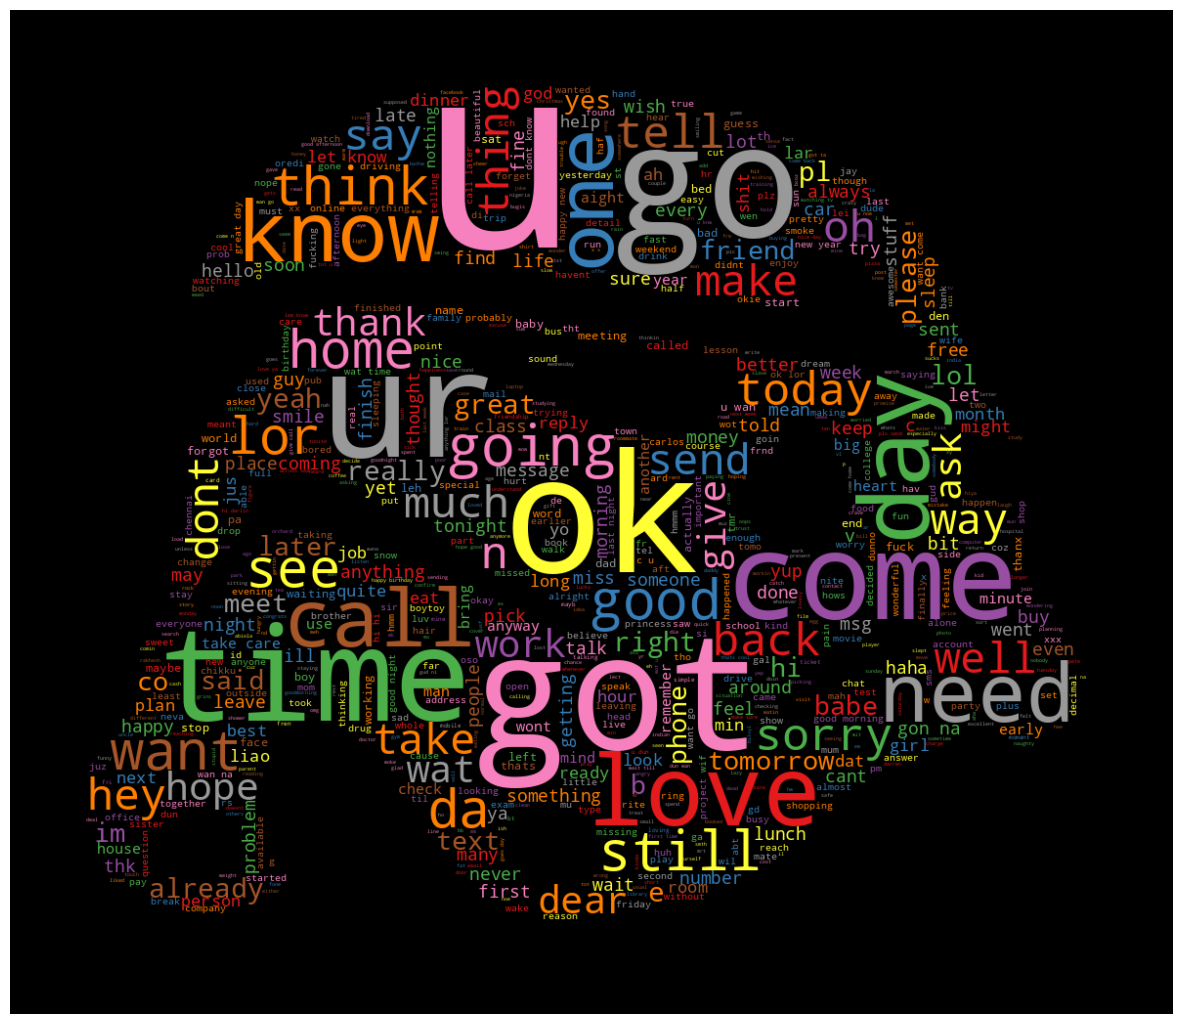

In [28]:
plt.figure(figsize=(15,15))
ham_data_wordcloud=df[df["label"]==0]
ham_text=" ".join(ham_data_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="Set1",mask=mask).generate(ham_text)
# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

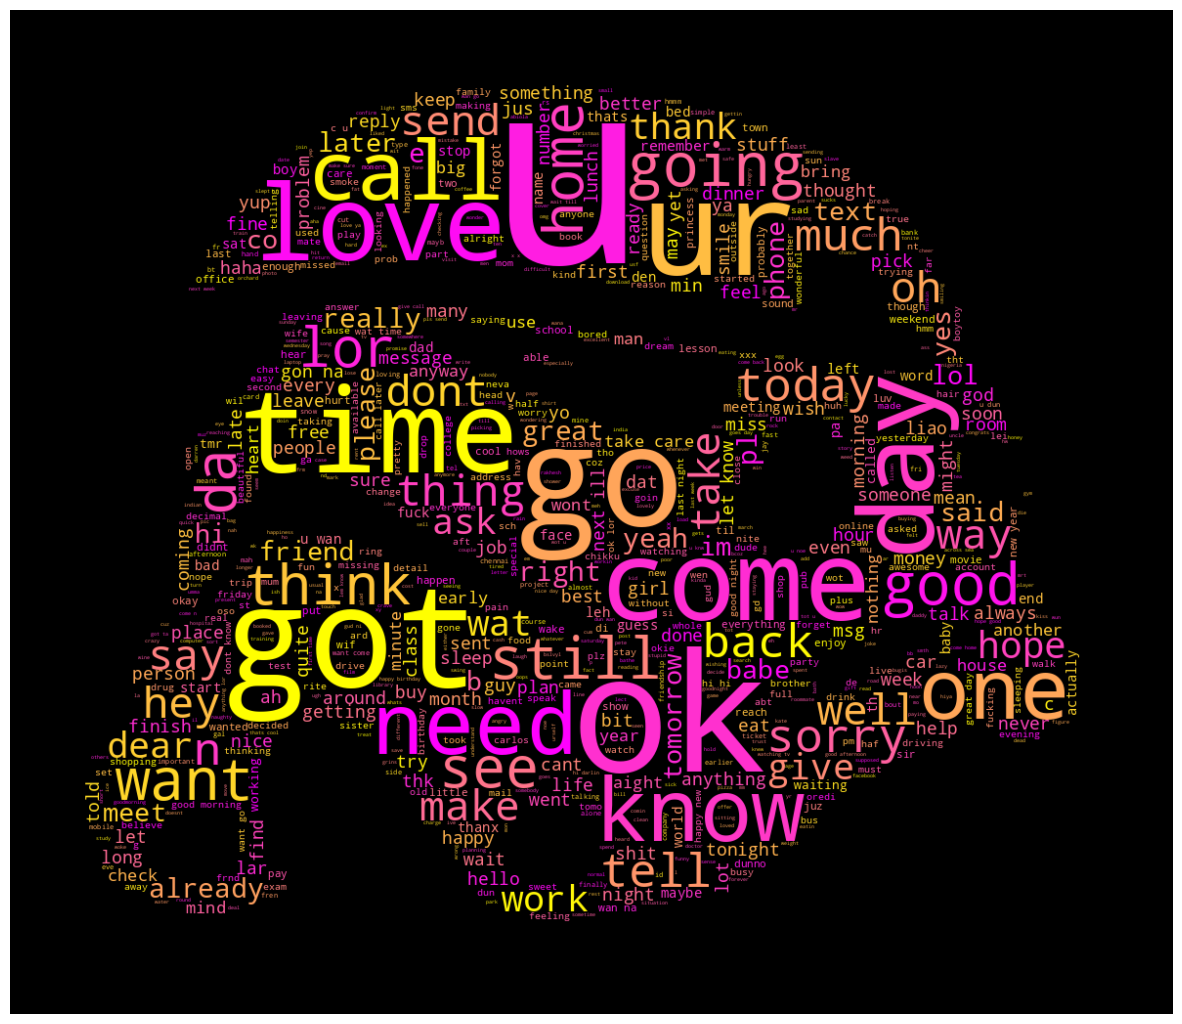

In [29]:
plt.figure(figsize=(15,15))
spam_data_wordcloud=df[df["label"]==1]
spam_text=" ".join(ham_data_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="spring",mask=mask).generate(spam_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

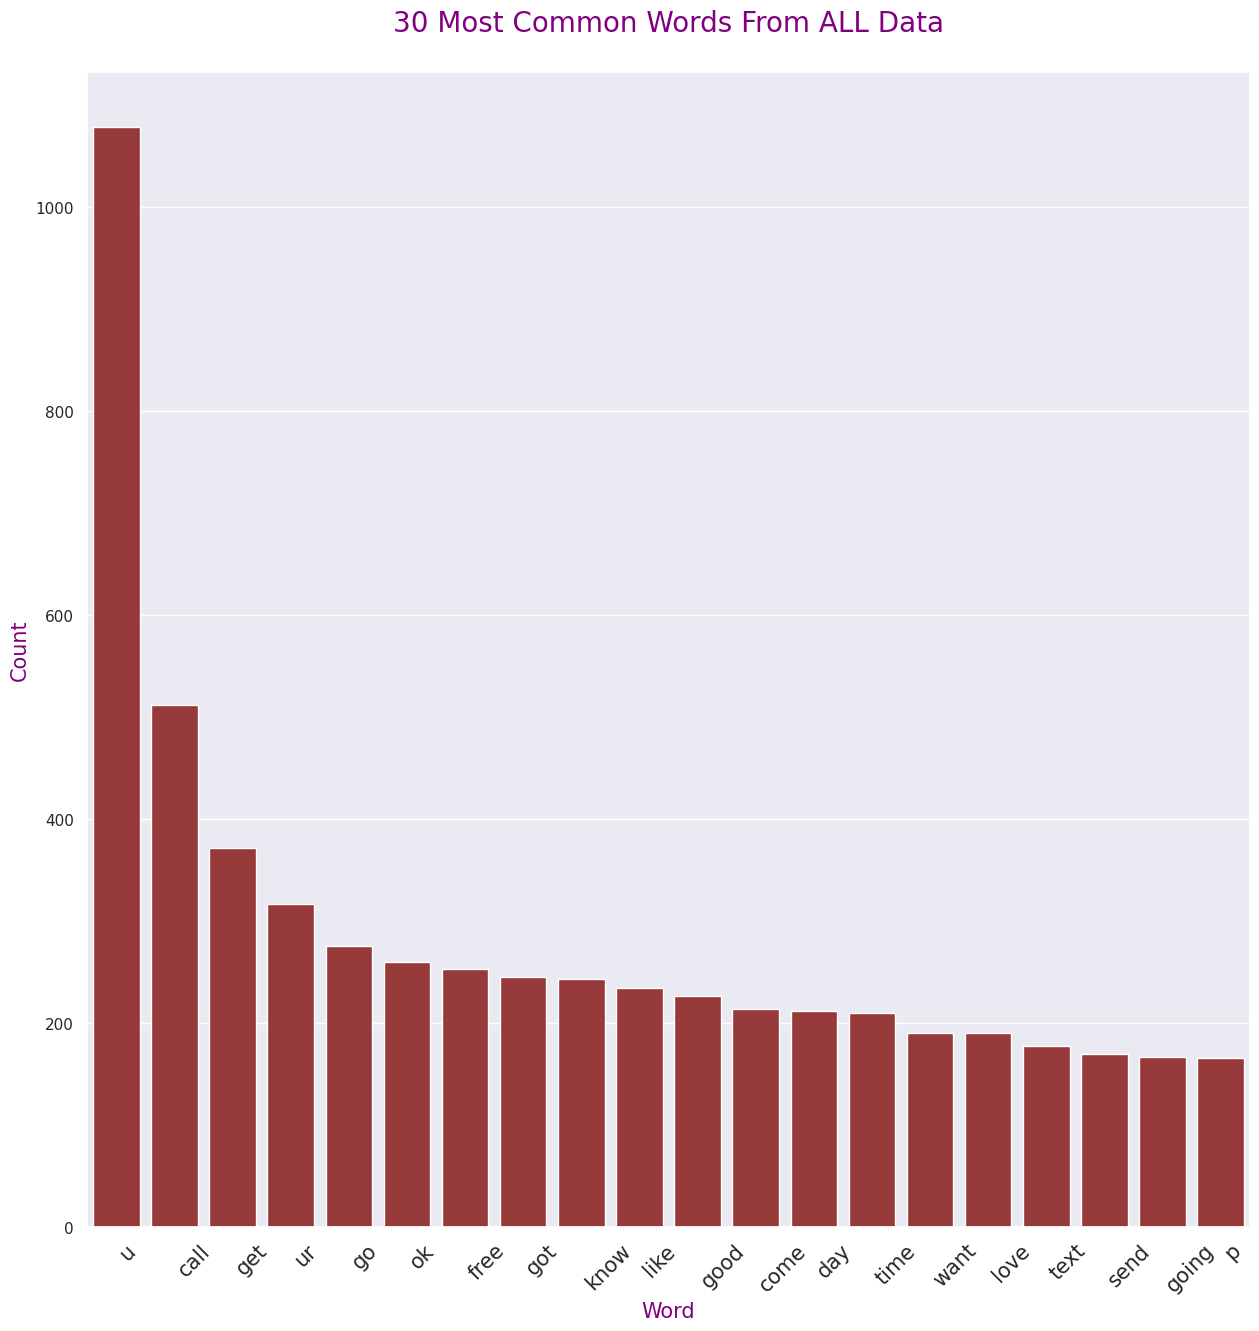

In [30]:
from collections import Counter
stop_words = set(stopwords.words('english'))


most_common_text = " ".join(df["text"].values.tolist())
most_common_text = most_common_text.translate(str.maketrans('', '', string.punctuation))
word_freq = most_common_text.split()
word_freq = [word for word in word_freq if word.lower() not in stop_words]

count_words = Counter(word_freq)
most_common_words = count_words.most_common(20)

data_frame = pd.DataFrame(most_common_words, columns=['Word', 'Count'])


sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,15)})
ax = sns.barplot(x="Word", y="Count", data=data_frame, color="brown")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left", fontsize=15)
plt.title("30 Most Common Words From ALL Data\n", fontsize=20, color="purple")
plt.xlabel("Word", fontsize=15, color="purple")
plt.ylabel("Count", fontsize=15, color="purple")

plt.show()

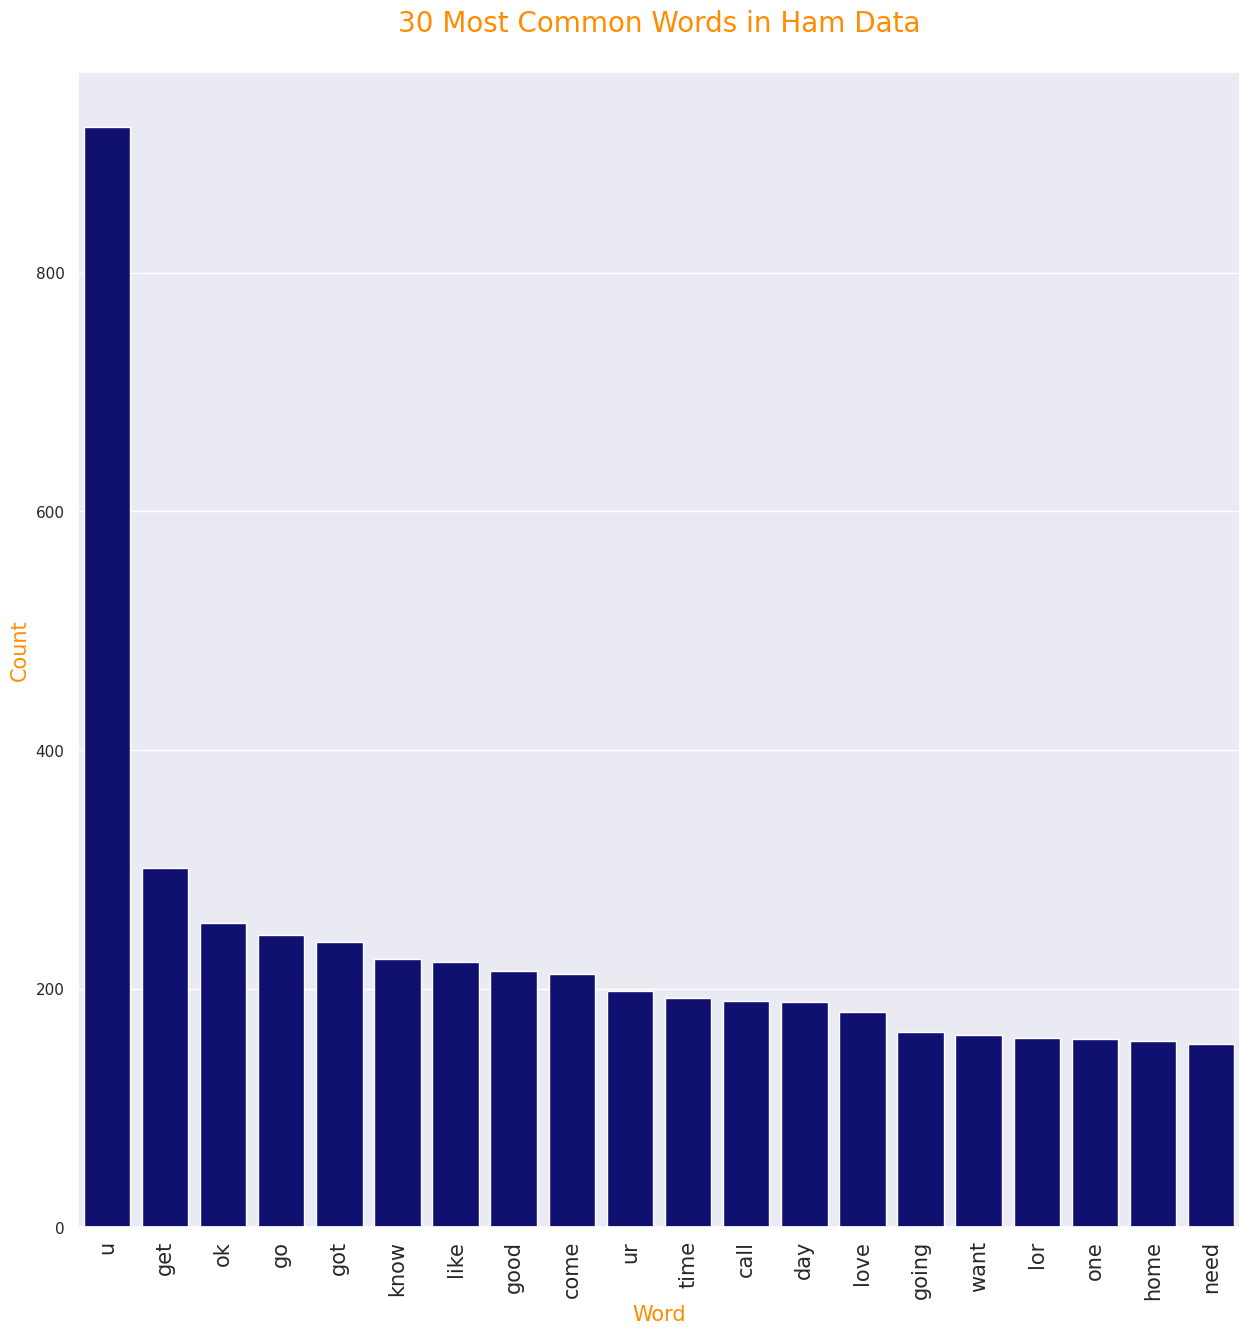

In [31]:
most_common_ham_word=df[df["label"]==0]
most_common_ham_text=" ".join(most_common_ham_word["text"].values.tolist())
most_common_ham_text = most_common_ham_text.translate(str.maketrans('', '', string.punctuation))
ham_word_freq=most_common_ham_text.split()
ham_word_freq=[word for word in ham_word_freq if word.lower() not in stop_words]
count_ham_words=Counter(ham_word_freq)
most_common_words_ham = count_ham_words.most_common(20)
ham_data_frame = pd.DataFrame(most_common_words_ham, columns=['Word', 'Count'])
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15,15)})
ax = sns.barplot(x="Word", y="Count", data=ham_data_frame,color="navy")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center",fontsize=15)
plt.title("30 Most Common Words in Ham Data\n", fontsize=20,color="darkorange")
plt.xlabel("Word",fontsize=15,color="darkorange")
plt.ylabel("Count",fontsize=15,color="darkorange")

plt.show()

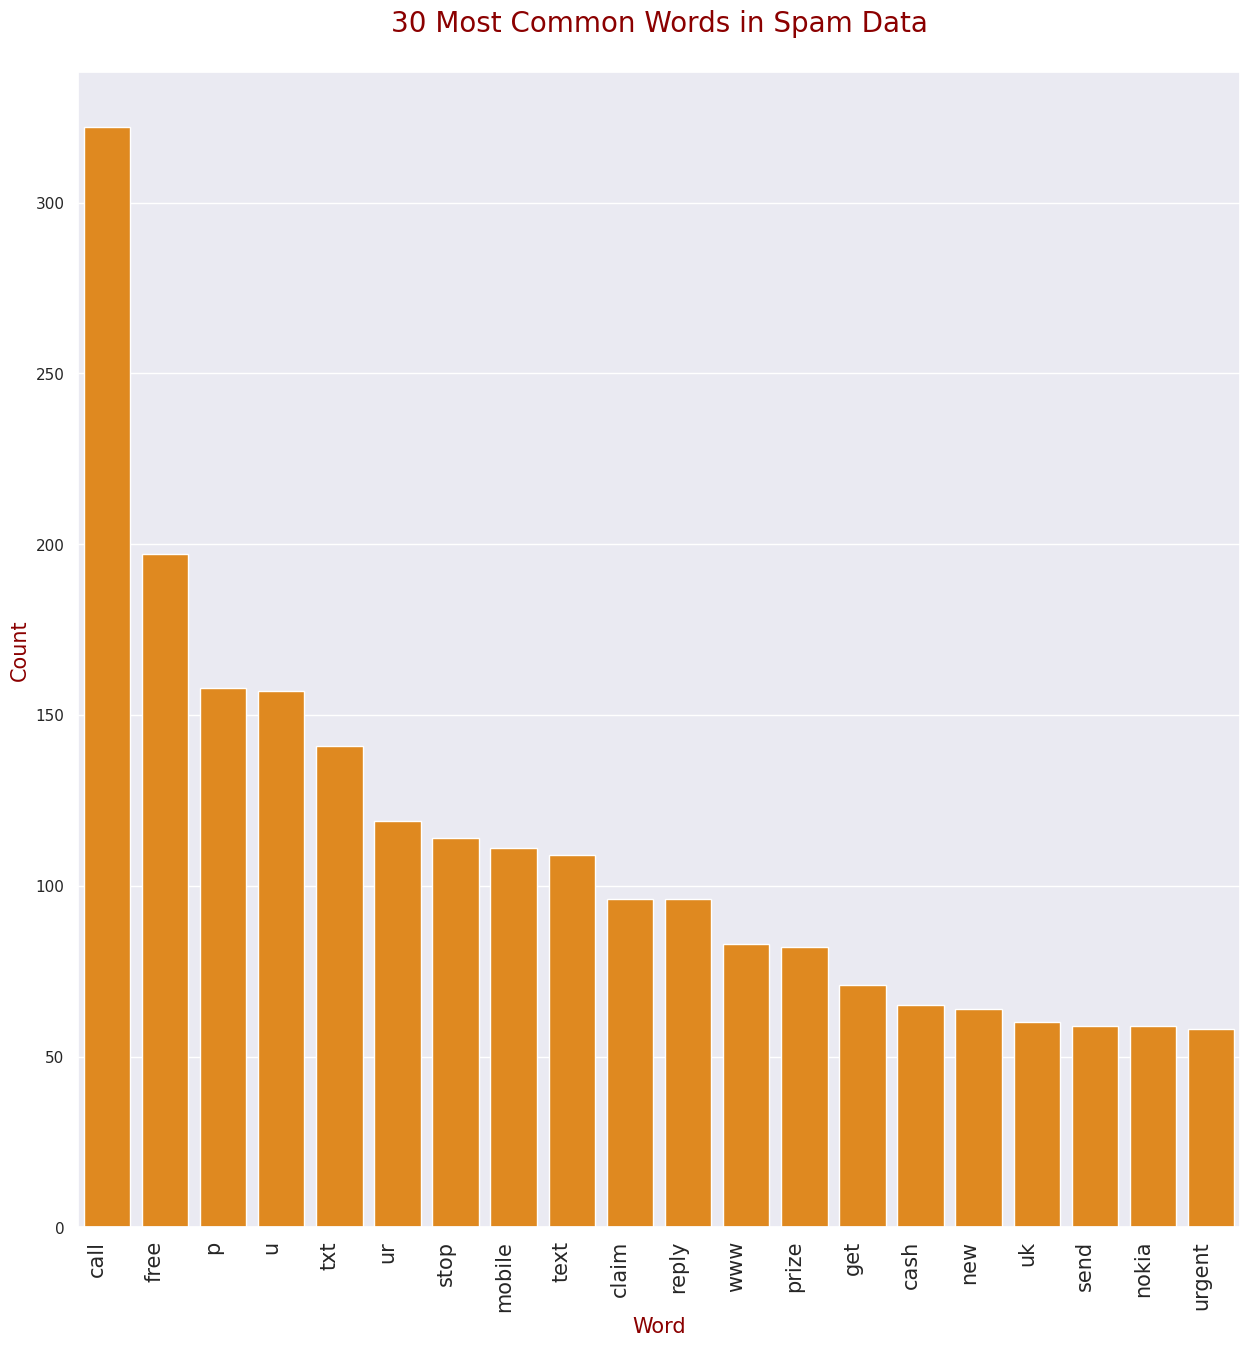

In [32]:
most_common_spam_word=df[df["label"]==1]
most_common_spam_text = " ".join(most_common_spam_word["text"].values.tolist())
most_common_spam_text = most_common_spam_text.translate(str.maketrans('', '', string.punctuation))
spam_word_freq = most_common_spam_text.split()
spam_word_freq = [word for word in spam_word_freq if word.lower() not in stop_words]
count_spam_words = Counter(spam_word_freq)
most_common_words_spam = count_spam_words.most_common(20)
spam_data_frame = pd.DataFrame(most_common_words_spam, columns=['Word', 'Count'])
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15,15)})
ax = sns.barplot(x="Word", y="Count", data=spam_data_frame, color="darkorange")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15)
plt.title("30 Most Common Words in Spam Data\n", fontsize=20, color="darkred")
plt.xlabel("Word", fontsize=15, color="darkred")
plt.ylabel("Count", fontsize=15, color="darkred")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


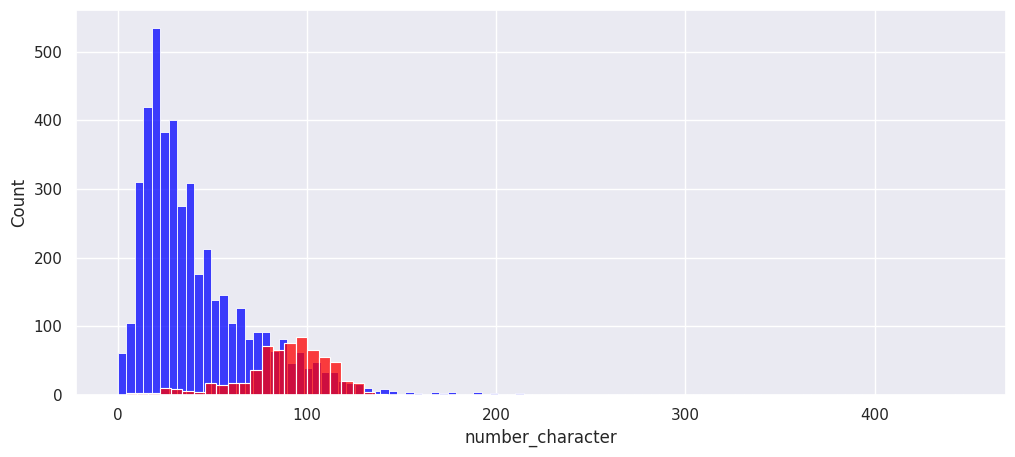

In [33]:
plt.figure(figsize=(12,5))
sns.histplot(df[df["label"]==0]["number_character"],color="blue")
sns.histplot(df[df["label"]==1]["number_character"], color="red")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


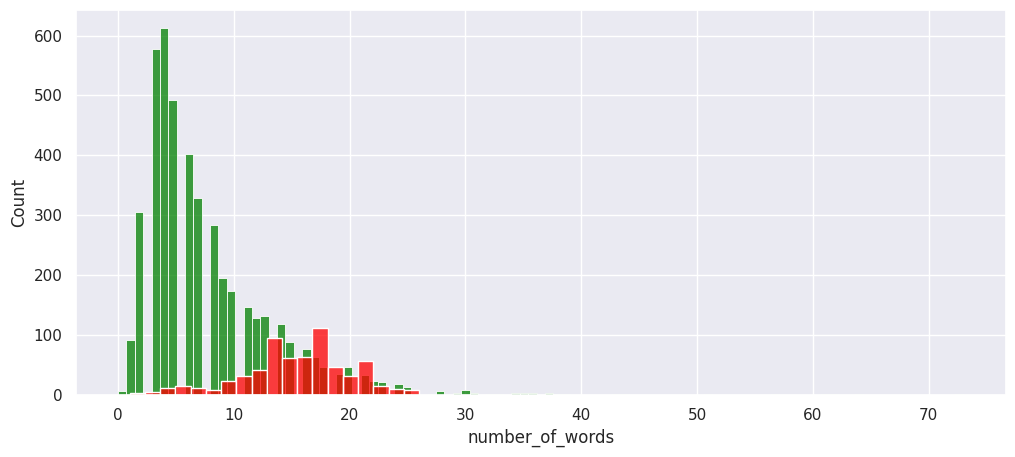

In [34]:
plt.figure(figsize=(12,5))
sns.histplot(df[df["label"]==0]["number_of_words"],color="green")
sns.histplot(df[df["label"]==1]["number_of_words"], color="red")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


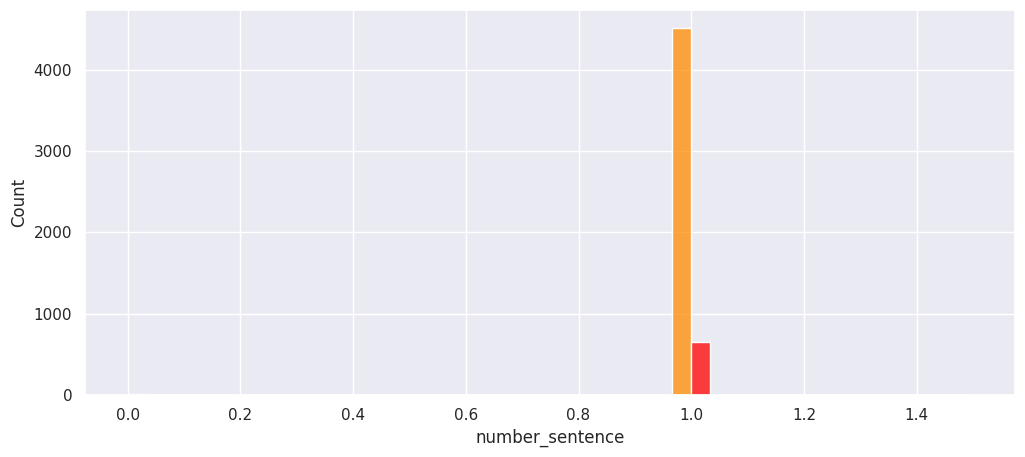

In [35]:
plt.figure(figsize=(12,5))
sns.histplot(df[df["label"]==0]["number_sentence"],color="darkorange",bins=30)
sns.histplot(df[df["label"]==1]["number_sentence"], color="red",bins=30)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

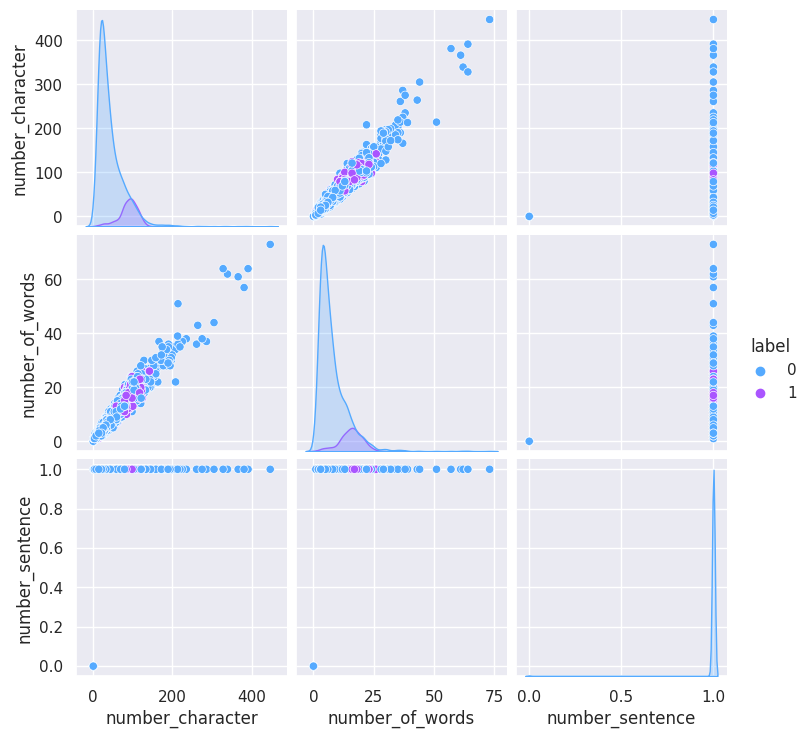

In [36]:
sns.pairplot(df,hue="label",palette="cool")
plt.show()

In [37]:
df.drop(columns=["number_character","number_of_words","number_sentence"],axis=1,inplace=True)


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
X=tf.fit_transform(df["text"])
Y=df["label"]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [40]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

In [41]:
svm=SVC(kernel='linear')
svm.fit(X_train,y_train)
pred1=svm.predict(X_test)
acc0=accuracy_score(y_test,pred1)
print("Accuracy score :",acc0)

Accuracy score : 0.9816247582205029


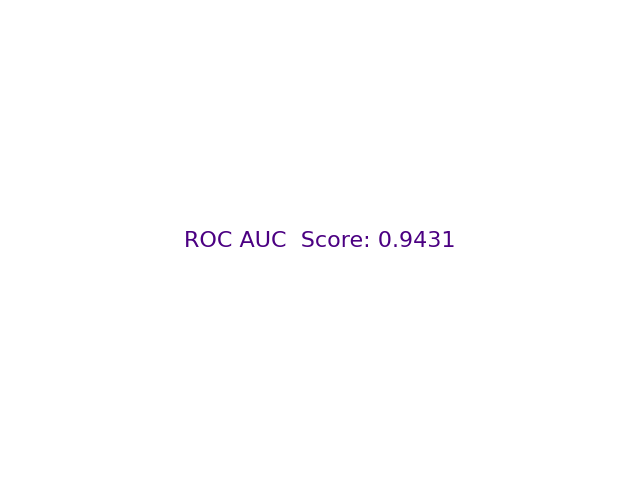

In [42]:
plt.figure(figsize=(8,6))
roc_auc = roc_auc_score(y_test, pred1)
plt.plot([])
plt.text(0,0, f'ROC AUC  Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center',color="indigo")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

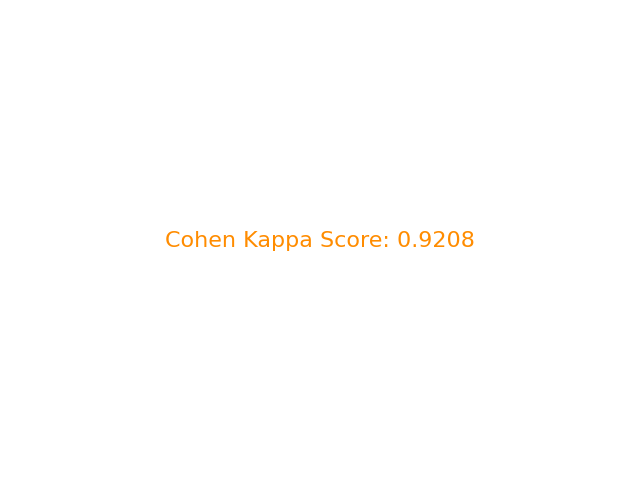

In [43]:
plt.figure(figsize=(8,6))
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test,pred1)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="darkorange")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

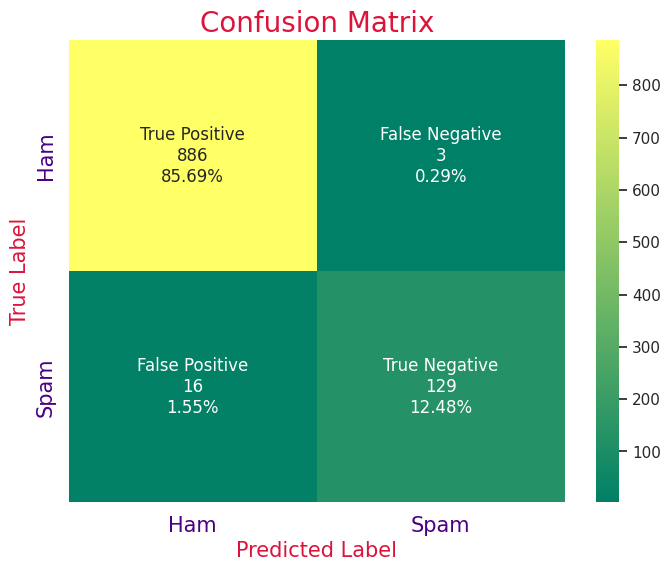

In [44]:
my_label_data=["Ham","Spam"]
my_matrix= confusion_matrix(y_test,pred1)
my_label = ["True Positive","False Negative","False Positive","True Negative"]
my_label_count=["{0:0.0f}".format(value) for value in my_matrix.flatten()]
percentage=["{0:.2%}".format(value) for value in my_matrix.flatten()/np.sum(my_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(my_label,my_label_count,percentage)]
labels=np.asarray(labels).reshape(2, 2)
# Plot confusion matrix as heatmap using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(my_matrix, annot=labels, cmap="summer", fmt="", cbar=True,
            xticklabels=my_label_data,yticklabels=my_label_data)
plt.xlabel("Predicted Label",fontsize=15,color="crimson")
plt.ylabel("True Label",fontsize=15,color="crimson")
plt.title("Confusion Matrix",fontsize=20,color="crimson")
plt.xticks(fontsize=15,color="indigo")
plt.yticks(fontsize=15,color="indigo")
plt.show()

In [45]:
print(classification_report(y_test,pred1,target_names=my_label_data))


              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       889
        Spam       0.98      0.89      0.93       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



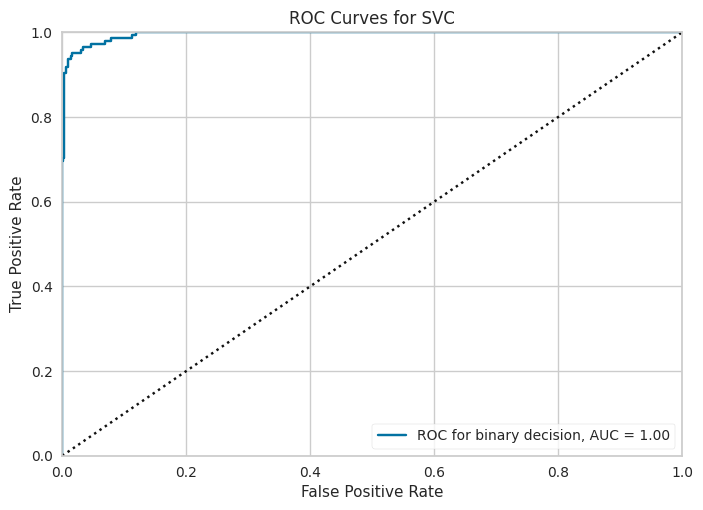

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [46]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(svm, classes=["ham", "spam"], binary=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [47]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
pred2 = bnb.predict(X_test)

acc1= accuracy_score(y_test,pred2)
print("Bernoulli Naive Bayes Accuracy:",acc1)

Bernoulli Naive Bayes Accuracy: 0.971953578336557


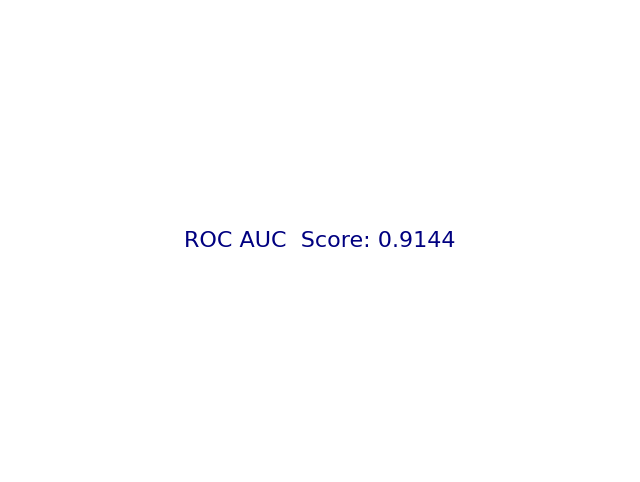

In [48]:
plt.figure(figsize=(8,6))
roc_auc = roc_auc_score(y_test, pred2)
plt.plot([])
plt.text(0,0, f'ROC AUC  Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center',color="navy")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

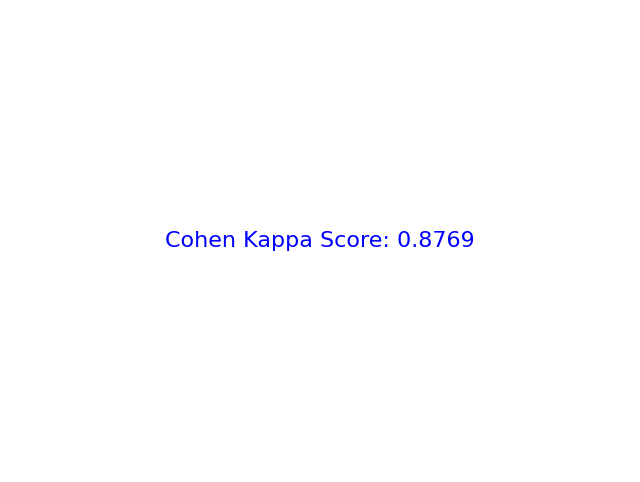

In [49]:
plt.figure(figsize=(8,6))
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test,pred2)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="blue")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

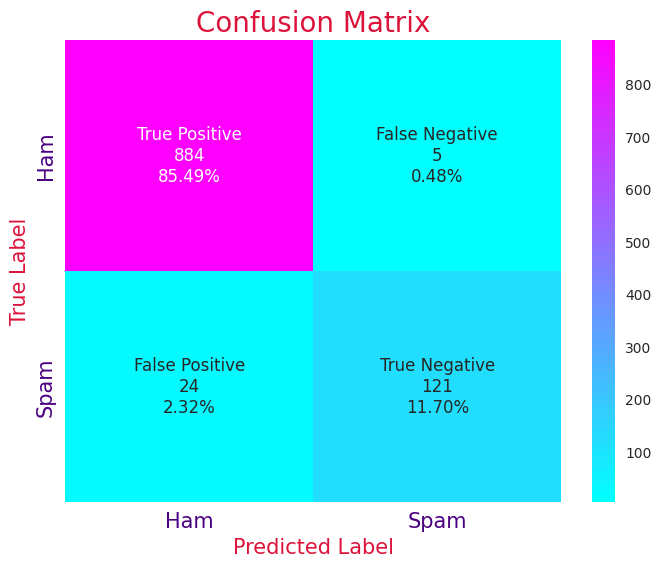

In [50]:
my_label_data=["Ham","Spam"]
my_matrix= confusion_matrix(y_test,pred2)
my_label = ["True Positive","False Negative","False Positive","True Negative"]
my_label_count=["{0:0.0f}".format(value) for value in my_matrix.flatten()]
percentage=["{0:.2%}".format(value) for value in my_matrix.flatten()/np.sum(my_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(my_label,my_label_count,percentage)]
labels=np.asarray(labels).reshape(2, 2)
# Plot confusion matrix as heatmap using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(my_matrix, annot=labels, cmap="cool", fmt="", cbar=True,
            xticklabels=my_label_data,yticklabels=my_label_data)
plt.xlabel("Predicted Label",fontsize=15,color="crimson")
plt.ylabel("True Label",fontsize=15,color="crimson")
plt.title("Confusion Matrix",fontsize=20,color="crimson")
plt.xticks(fontsize=15,color="indigo")
plt.yticks(fontsize=15,color="indigo")
plt.show()

In [51]:
print(classification_report(y_test,pred2,target_names=my_label_data))

              precision    recall  f1-score   support

         Ham       0.97      0.99      0.98       889
        Spam       0.96      0.83      0.89       145

    accuracy                           0.97      1034
   macro avg       0.97      0.91      0.94      1034
weighted avg       0.97      0.97      0.97      1034



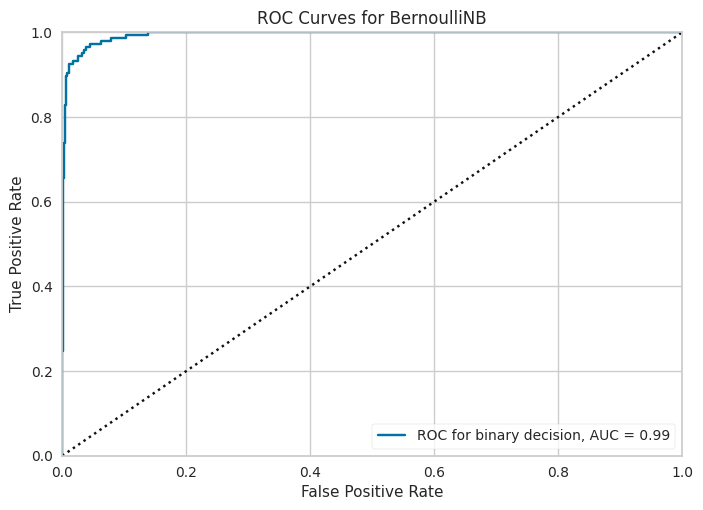

<Axes: title={'center': 'ROC Curves for BernoulliNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [52]:
visualizer = ROCAUC(bnb, classes=["ham", "spam"], binary=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [53]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
pred3 = mnb.predict(X_test)

acc2 = accuracy_score(y_test, pred3)
print("Multinomial Naive Bayes Accuracy:",acc2)

Multinomial Naive Bayes Accuracy: 0.9680851063829787


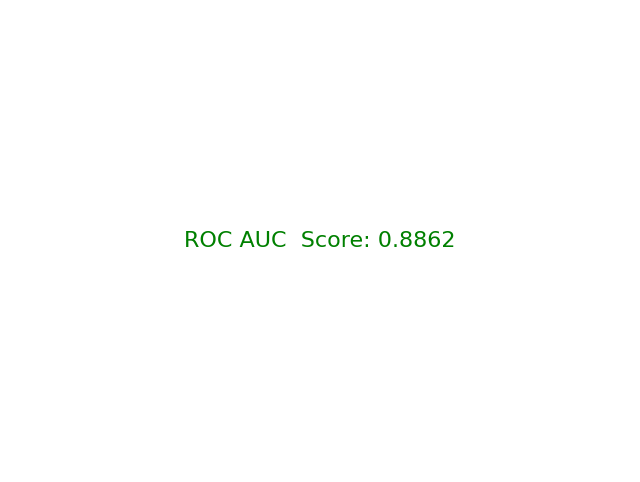

In [54]:
plt.figure(figsize=(8,6))
roc_auc = roc_auc_score(y_test, pred3)
plt.plot([])
plt.text(0,0, f'ROC AUC  Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center',color="green")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

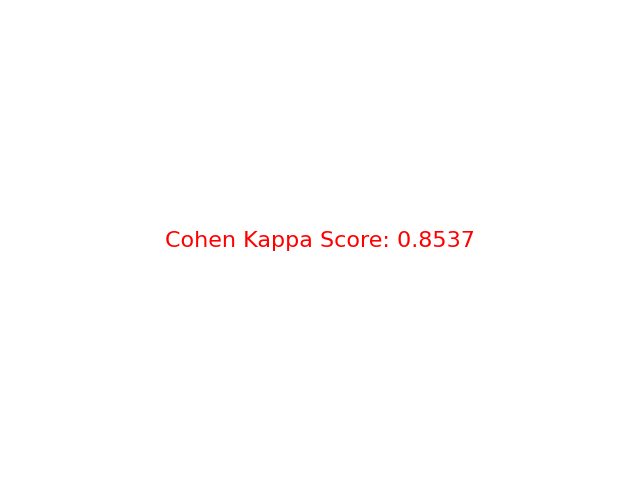

In [55]:
plt.figure(figsize=(8,6))
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test,pred3)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="red")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

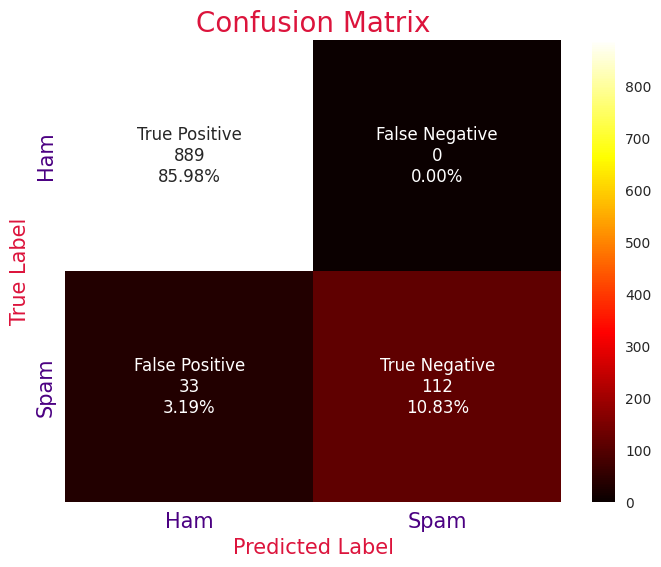

In [56]:
my_label_data=["Ham","Spam"]
my_matrix= confusion_matrix(y_test,pred3)
my_label = ["True Positive","False Negative","False Positive","True Negative"]
my_label_count=["{0:0.0f}".format(value) for value in my_matrix.flatten()]
percentage=["{0:.2%}".format(value) for value in my_matrix.flatten()/np.sum(my_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(my_label,my_label_count,percentage)]
labels=np.asarray(labels).reshape(2, 2)
# Plot confusion matrix as heatmap using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(my_matrix, annot=labels, cmap="hot", fmt="", cbar=True,
            xticklabels=my_label_data,yticklabels=my_label_data)
plt.xlabel("Predicted Label",fontsize=15,color="crimson")
plt.ylabel("True Label",fontsize=15,color="crimson")
plt.title("Confusion Matrix",fontsize=20,color="crimson")
plt.xticks(fontsize=15,color="indigo")
plt.yticks(fontsize=15,color="indigo")
plt.show()

In [57]:
print(classification_report(y_test,pred3,target_names=my_label_data))

              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       889
        Spam       1.00      0.77      0.87       145

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034



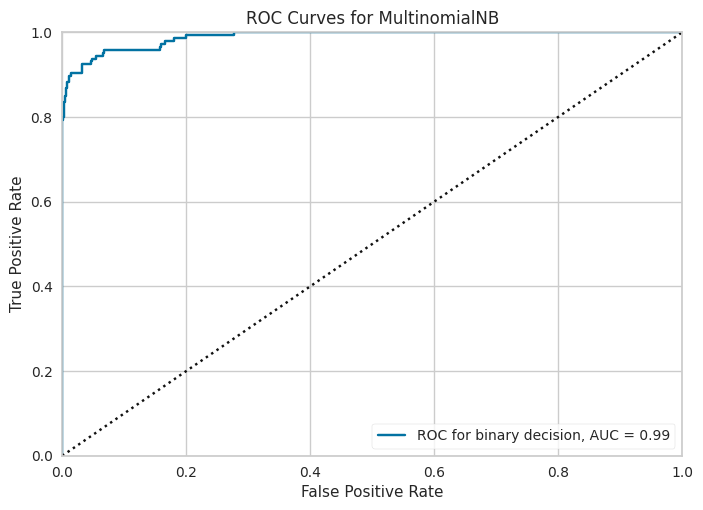

<Axes: title={'center': 'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [58]:
visualizer = ROCAUC(mnb, classes=["ham", "spam"], binary=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

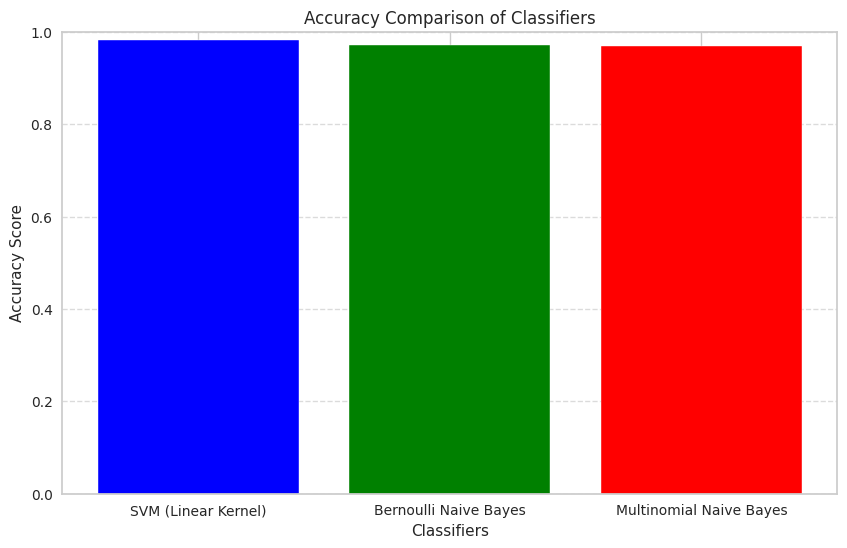

In [59]:
accuracy_scores = [acc0, acc1, acc2]
classifiers = ['SVM (Linear Kernel)', 'Bernoulli Naive Bayes', 'Multinomial Naive Bayes']

plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracy_scores, color=['blue', 'green', 'red'])
plt.xlabel('Classifiers')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Comparison of Classifiers')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 as accuracy scores are in that range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [60]:
custom_data = ["Banks rarely text their customers with important information or updates. Scammers frequently pose as banks to trick customers into revealing valuable information.Example: ACTION REQUIRED. Please verify your Bank of America account information to avoid a hold on your account. Click here to confirm: [Link]"]

custom_data_transformed = tf.transform(custom_data)


predictions = mnb.predict(custom_data_transformed)

if predictions==0:
    print("Message is Ham")
else:
    print("Message is Spam")

Message is Ham
